In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
sns.set()

In [2]:
#import warnings
#warnings.filterwarnings("ignore")

In [3]:
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data.index = pd.DatetimeIndex(data.index.values, freq = data.index.inferred_freq)

First, we need to choose the signal we want to process and make it stationary using the differences between consecutive observations.

In [4]:
#names = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']
names = ['L_T1', 'L_T2', 'L_T3', 'F_PU1', 'F_PU2', 'F_PU10']

# function that we use to make the signal stationary (we lose the first observation)
delay = 24*7
def difference(orig_series):
    diff = list()
    for i in range(delay, len(orig_series)):
        value = orig_series.iloc[i] - orig_series.iloc[i - delay]
        diff.append(value)
    return pd.Series(diff, orig_series.index[delay:])

In [5]:
signals = {} # signals we want to model with ARMA
for name in names:
    series = pd.Series(data[name], data.index)
    signals[name] = series
    display(series.head(2))

2014-01-06 00:00:00    0.50973
2014-01-06 01:00:00    0.41258
Freq: H, Name: L_T1, dtype: float64

2014-01-06 00:00:00    2.049003
2014-01-06 01:00:00    2.009072
Freq: H, Name: L_T2, dtype: float64

2014-01-06 00:00:00    3.191145
2014-01-06 01:00:00    3.642565
Freq: H, Name: L_T3, dtype: float64

2014-01-06 00:00:00    98.998444
2014-01-06 01:00:00    99.095901
Freq: H, Name: F_PU1, dtype: float64

2014-01-06 00:00:00    99.018150
2014-01-06 01:00:00    99.115639
Freq: H, Name: F_PU2, dtype: float64

2014-01-06 00:00:00    30.512712
2014-01-06 01:00:00    30.480455
Freq: H, Name: F_PU10, dtype: float64



Processing signal 'L_T1'


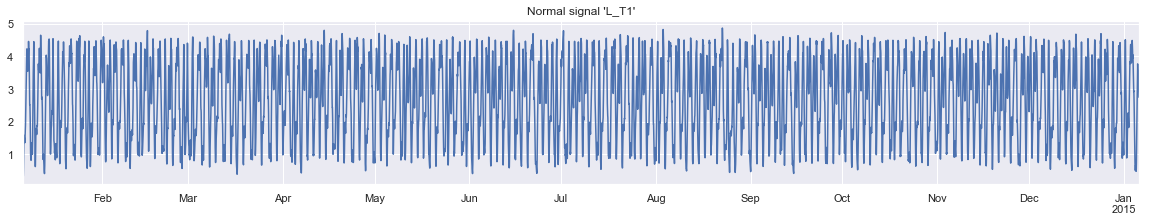

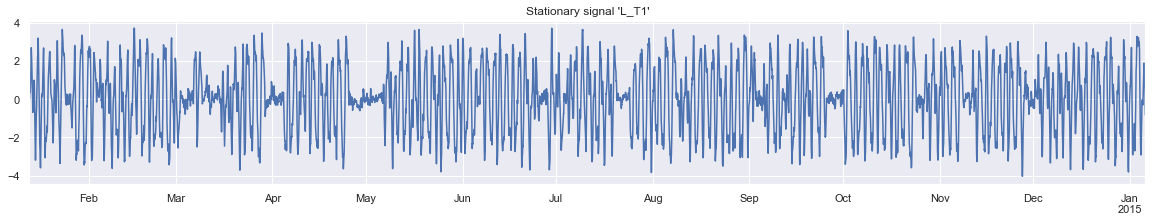



Processing signal 'L_T2'


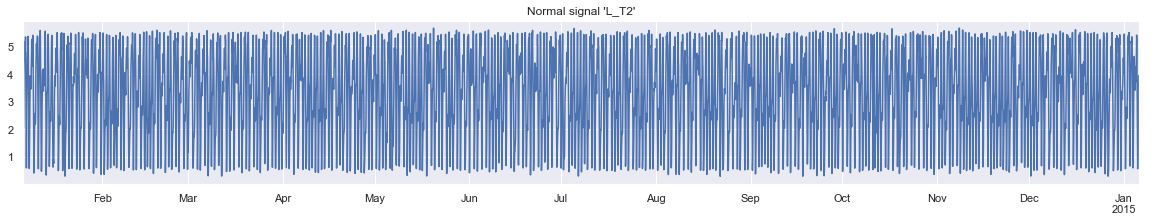

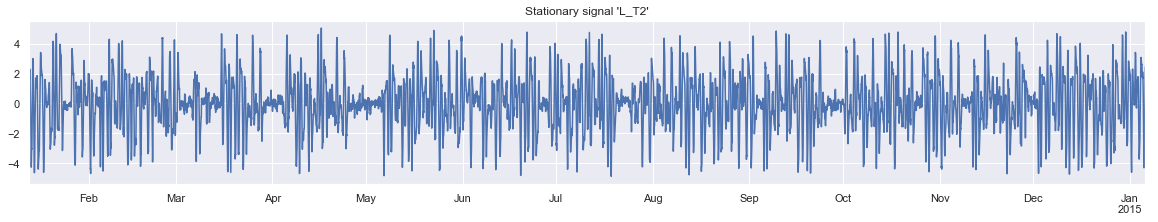



Processing signal 'L_T3'


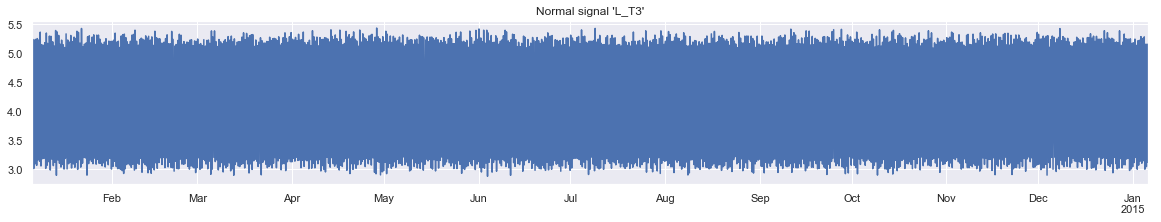

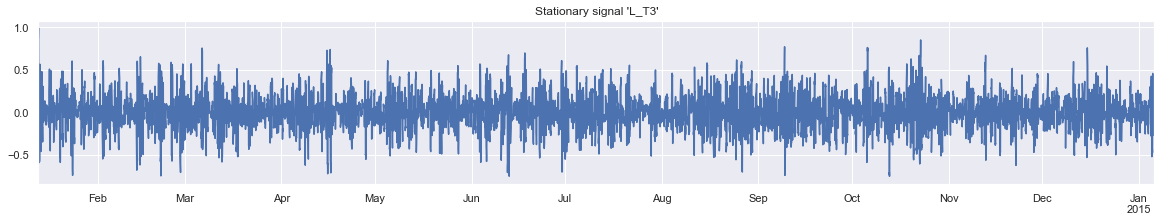



Processing signal 'F_PU1'


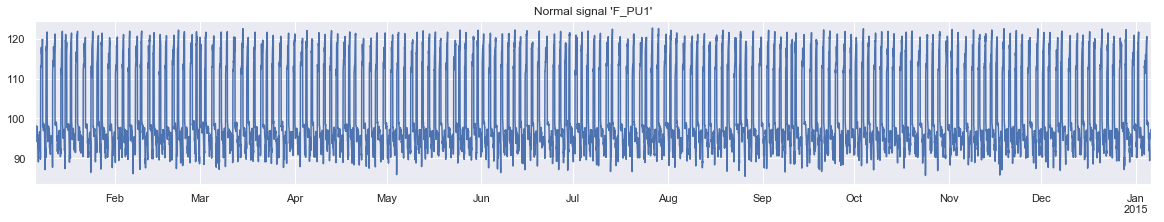

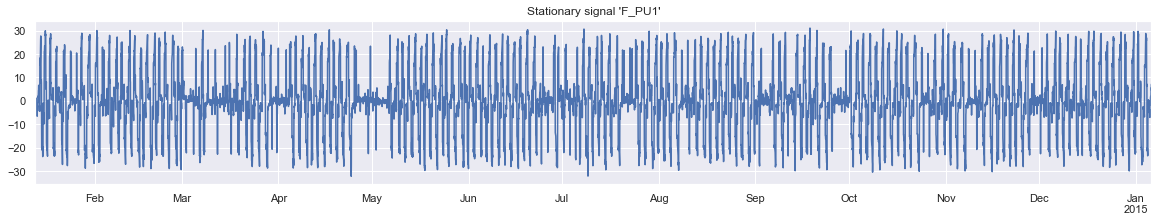



Processing signal 'F_PU2'


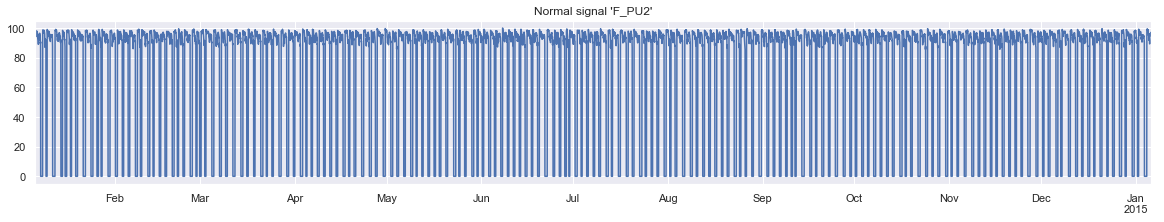

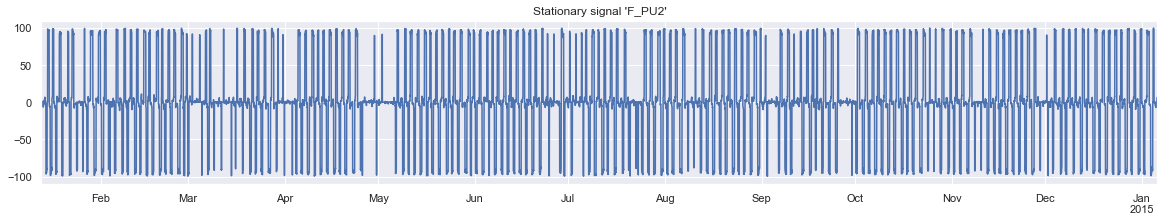



Processing signal 'F_PU10'


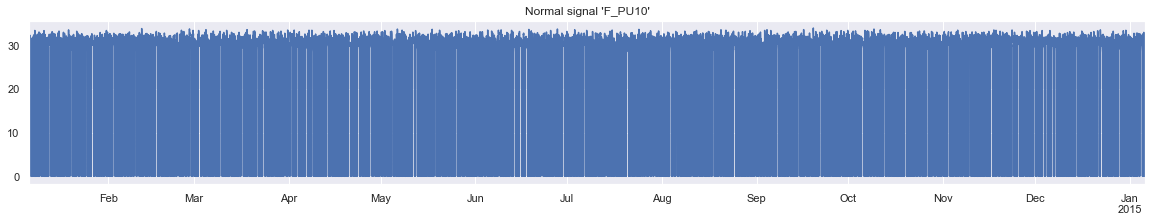

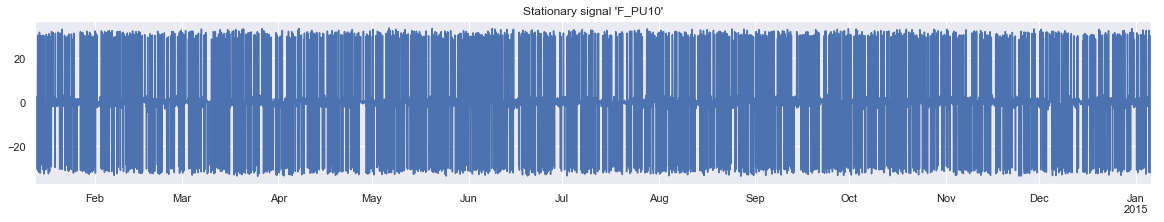

In [6]:
for signal in signals.keys():
    print(f"\n\nProcessing signal '{signal}'")
    
    series = signals[signal]
    
    # visualize it
    series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{signal}'")
    plt.show()
    
    stationary = difference(series)

    # visualize it
    stationary.plot(figsize=(20,3))
    plt.title(f"Stationary signal '{signal}'")
    plt.show()
              
    signals[signal] = stationary

### Plot ACF and PACF of the signal, to retrieve the values of p and q of the ARMA



Computing ACF and PACF for 'L_T1'


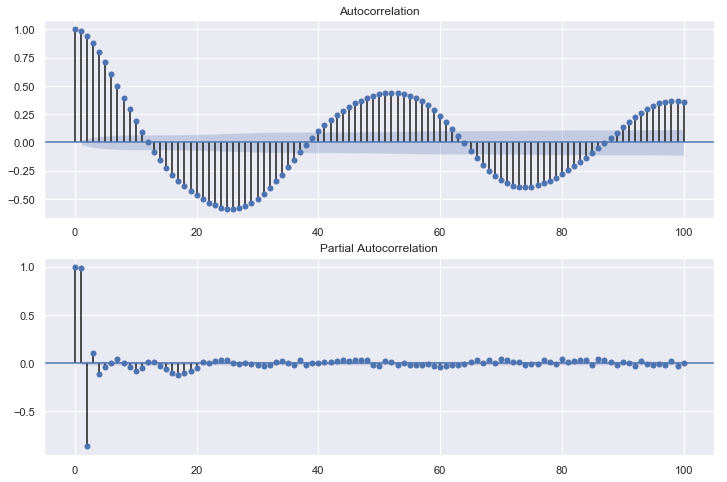



Computing ACF and PACF for 'L_T2'


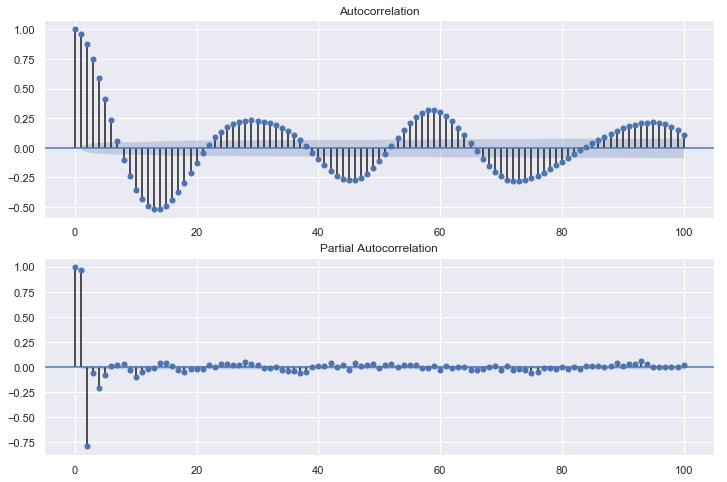



Computing ACF and PACF for 'L_T3'


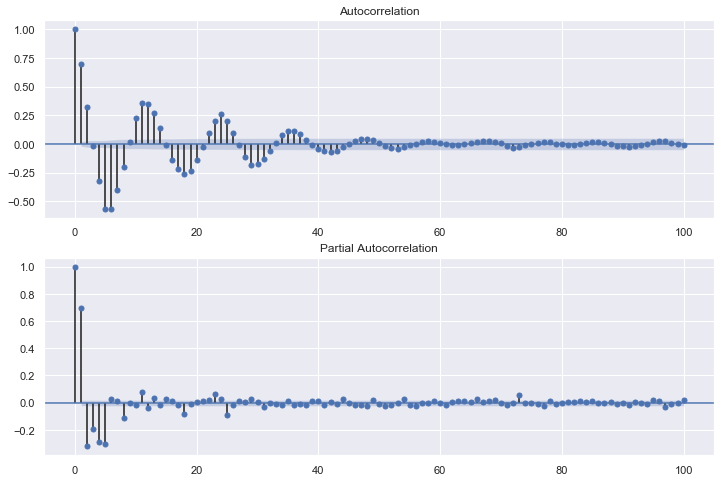



Computing ACF and PACF for 'F_PU1'


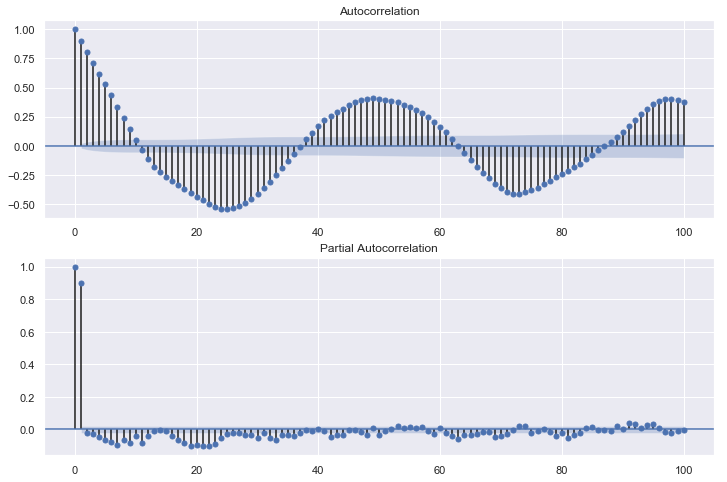



Computing ACF and PACF for 'F_PU2'


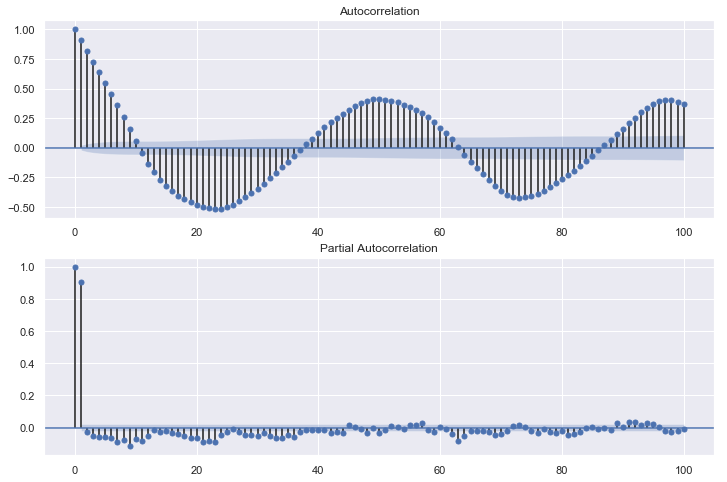



Computing ACF and PACF for 'F_PU10'


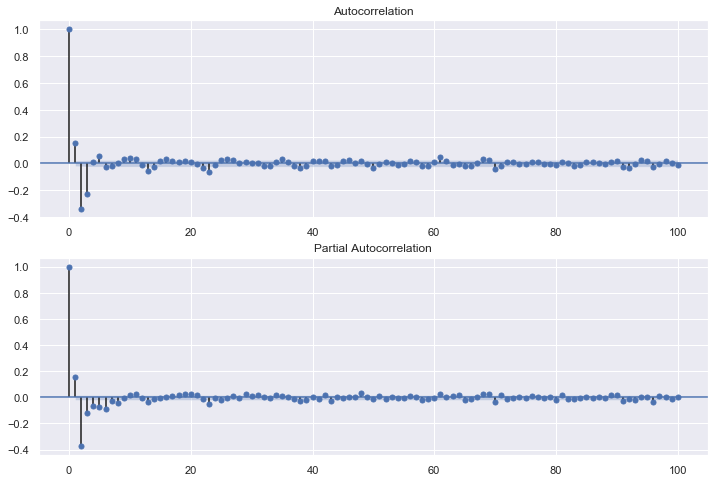

In [7]:
for signal in signals.keys():
    print(f"\n\nComputing ACF and PACF for '{signal}'")
    
    series = signals[signal]
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=100, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=100, ax=ax2)
    plt.show()

By looking at the plot, we should choose p=1 and q=1 for all the signals.

## Grid Search

In [8]:
import warnings
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [9]:
# import warnings
# warnings.filterwarnings("ignore")

Now we can define a function for evaluating the different parameters for the ARMA model

In [10]:
#resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_arima_model_mse(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    error = np.mean(aics)
    return error

def evaluate_arima_model_aic(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit(disp=0)
    return model_fit.aic

Now we define a method that loops over different sets of parameters for ARMA and evaluates the performance based on AIC.

In [11]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    #error = evaluate_arima_model_mse(dataset, order)
                    error = evaluate_arima_model_aic(dataset, order)
                    if error < best_score:
                        best_score, best_cfg = error, order
                    #print('ARIMA%s MSE=%.3f' % (order,error))
                    print('ARIMA%s AIC=%.3f' % (order,error))
                except:
                    continue # the try/catch is done because the optimization can fail: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
    #print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [12]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4]
d_values = [0] # no I component --> we only want ARMA and not ARIMA
q_values = range(0, 3)
warnings.filterwarnings("ignore")

# this TAKES A LOT, run it only if you really really really want to
for signal in signals.keys():
    print(f"\n\nComputing AIC values for '{signal}'")    
    series = signals[signal]
    evaluate_models(series.values, p_values, d_values, q_values)



Computing AIC values for 'L_T1'
ARIMA(0, 0, 0) AIC=33432.462
ARIMA(0, 0, 1) AIC=22060.725
ARIMA(1, 0, 0) AIC=3535.650
ARIMA(1, 0, 1) AIC=-3147.181
ARIMA(1, 0, 2) AIC=-5675.457
ARIMA(2, 0, 0) AIC=-8165.757
ARIMA(2, 0, 1) AIC=-8239.587
ARIMA(2, 0, 2) AIC=-8307.112
ARIMA(3, 0, 0) AIC=-8222.815
ARIMA(3, 0, 1) AIC=-8301.327
ARIMA(3, 0, 2) AIC=-8465.951
ARIMA(4, 0, 0) AIC=-8319.998
ARIMA(4, 0, 1) AIC=-8448.849
ARIMA(4, 0, 2) AIC=-8467.237
Best ARIMA(4, 0, 2) AIC=-8467.237


Computing AIC values for 'L_T2'
ARIMA(0, 0, 0) AIC=34560.240
ARIMA(0, 0, 1) AIC=23839.417
ARIMA(1, 0, 0) AIC=11695.683
ARIMA(1, 0, 1) AIC=6556.831
ARIMA(1, 0, 2) AIC=5042.572
ARIMA(2, 0, 0) AIC=3268.803
ARIMA(2, 0, 1) AIC=3209.340
ARIMA(2, 0, 2) AIC=2849.047
ARIMA(3, 0, 0) AIC=3242.964
ARIMA(3, 0, 1) AIC=3004.114
ARIMA(3, 0, 2) AIC=2850.925
ARIMA(4, 0, 0) AIC=2847.698
ARIMA(4, 0, 1) AIC=2805.382
ARIMA(4, 0, 2) AIC=2766.572
Best ARIMA(4, 0, 2) AIC=2766.572


Computing AIC values for 'L_T3'
ARIMA(0, 0, 0) AIC=-1267.774
AR

Based on the results of ACF and PACF we should use q=1 and p=1. However, because of the way AIC works, it is likely to select a very complex model when testing too many models (). This is the case, where AIC suggests us to select the most complex model.    

If we look carefully to the values of AIC, though, we can see how there is a big drop when 'q' goes from 0 to 1. After this moment, the value of AIC goes down very slowly, suggesting that the added value of using a more complex parameter is not significant.   

We analyse for each signal where the drops happens, and we will use that order for the following steps

In [13]:
# values taken by grid search above
# orders = {
#     'L_T1': (2, 0, 0),
#     'L_T2': (2, 0, 0),
#     'L_T3': (2, 0, 1),
#     'L_T4': (1, 0, 1),
#     'L_T5': (2, 0, 1),
#     'L_T6': (1, 0, 2),
#     'L_T7': (1, 0, 1)
# }

orders = {
    'L_T1': (2, 0, 0),
    'L_T2': (2, 0, 0),
    'L_T3': (2, 0, 1),
    'F_PU1': (1, 0, 0),
    'F_PU10': (0, 0, 2),
    'F_PU2': (2, 0, 1),
}

In [14]:
# https://github.com/statsmodels/statsmodels/issues/2788 SARIMAX is needed to include new observations in time
def make_predictions_sarimax(trn_series, tst_series, order):
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    start_idx = tst_series.index[0]
    
    for tst_idx in tst_series.index:
        mod_tst = sm.tsa.SARIMAX(tst_series[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        
    return predictions
    

We choose training set 1 to fit our ARMA. This is because there are no attacks in this training set --> we can learn the normal behaviour

Predicting and plotting prediction for 'L_T1'


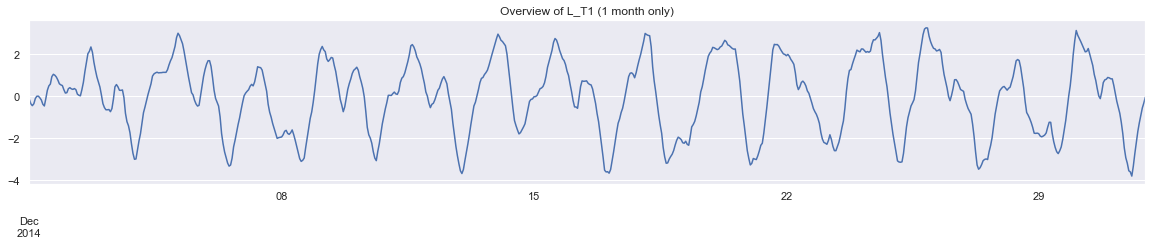

7585 hours used for training, 1008 for testing.


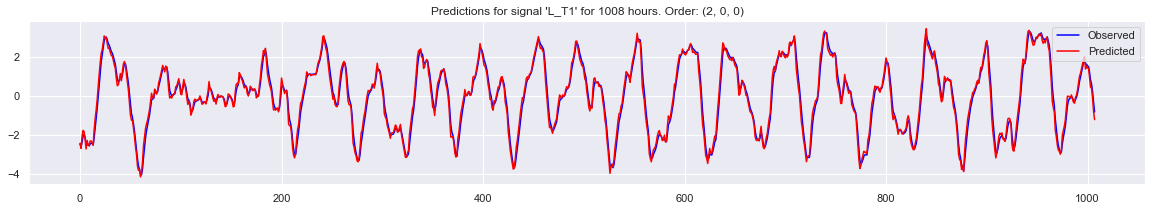

MSE: 0.07410057716927952
Predicting and plotting prediction for 'L_T2'


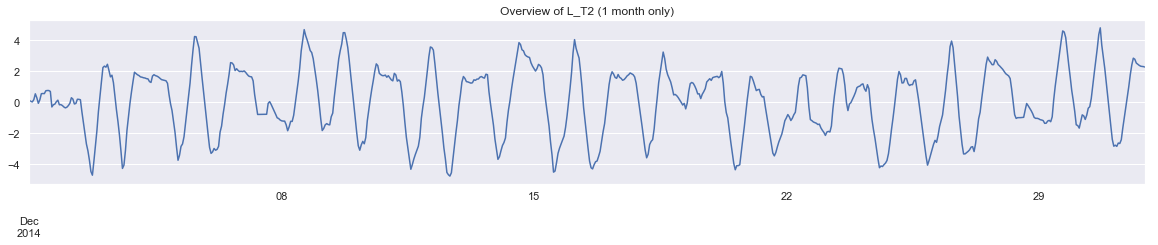

7585 hours used for training, 1008 for testing.


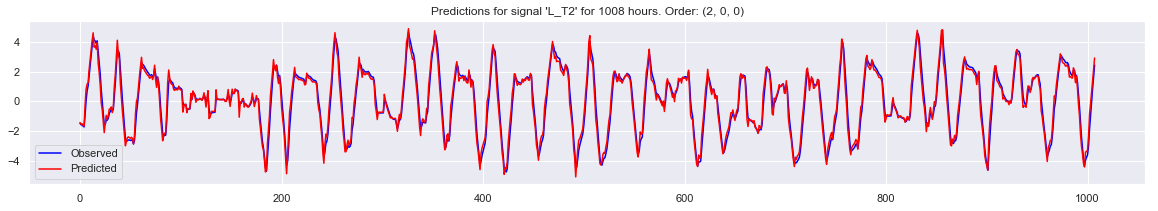

MSE: 0.18135727652017905
Predicting and plotting prediction for 'L_T3'


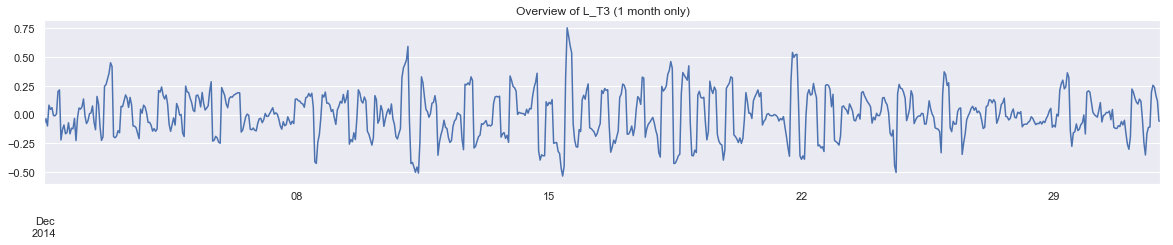

7585 hours used for training, 1008 for testing.


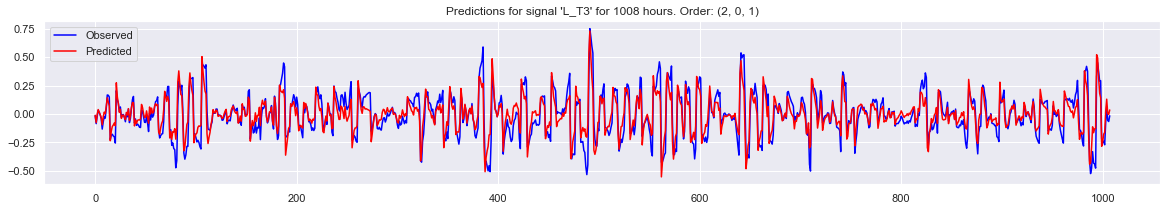

MSE: 0.008278180445742451
Predicting and plotting prediction for 'F_PU1'


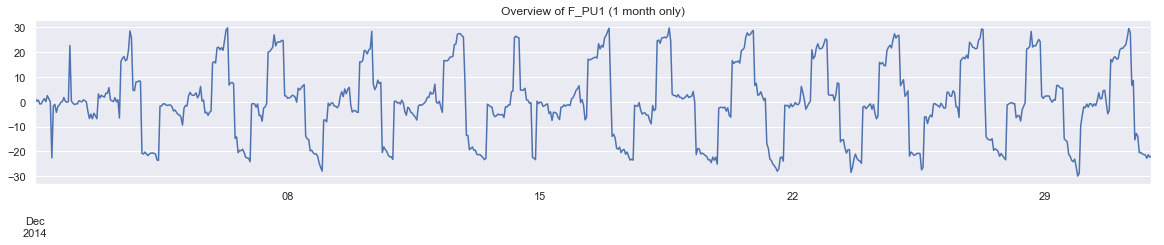

7585 hours used for training, 1008 for testing.


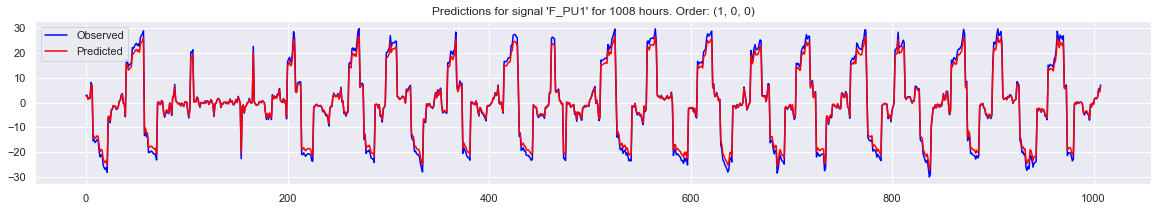

MSE: 2.19446962109725
Predicting and plotting prediction for 'F_PU2'


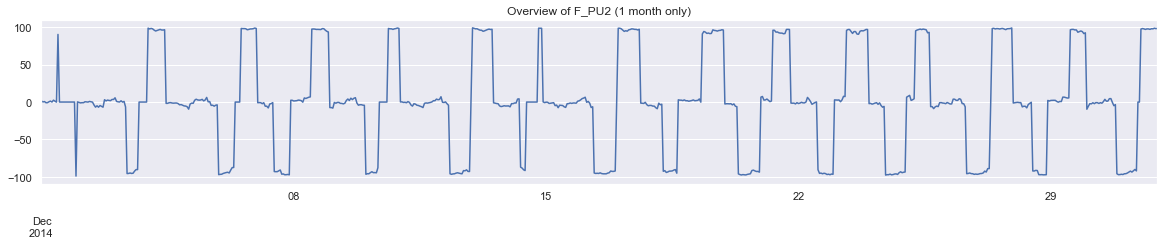

7585 hours used for training, 1008 for testing.


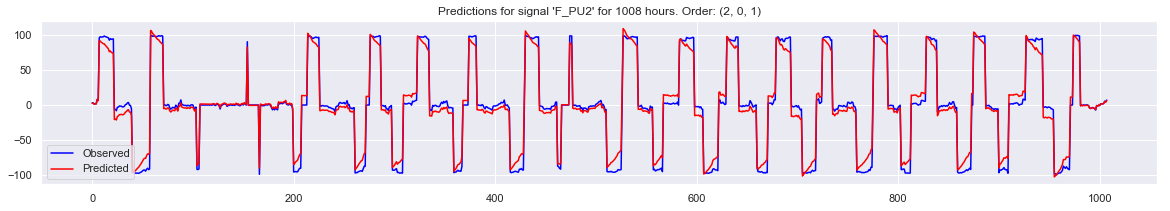

MSE: 90.59434137316839
Predicting and plotting prediction for 'F_PU10'


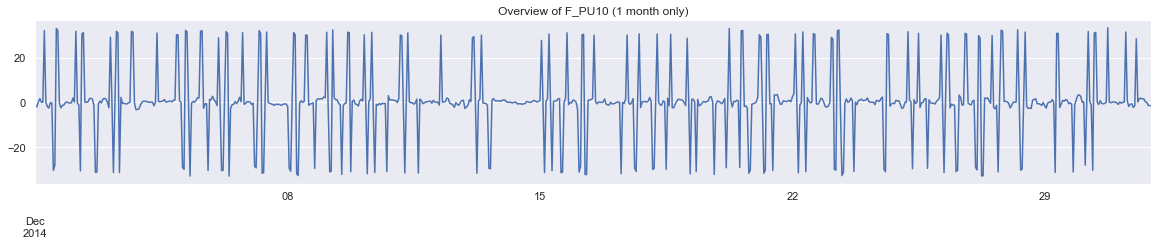

7585 hours used for training, 1008 for testing.


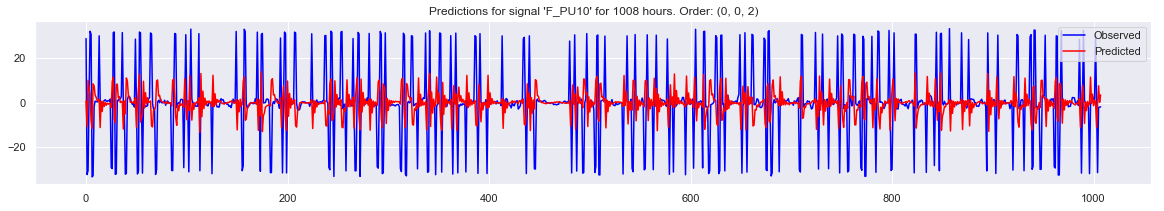

MSE: 260.0519154562822


In [15]:
for signal in signals.keys():
    print(f"Predicting and plotting prediction for '{signal}'")
    signal_data = signals[signal]
    #print("{} data points for signal '{}'".format(signal_data.shape[0], signal))
    #print(signal_data.head(5))
    
    signal_data.loc['2014-12'].plot(figsize=(20, 3), title=f"Overview of {signal} (1 month only)")
    plt.show()
    
    hours_to_predict = 24 * 7 * 6
    split_point = len(signal_data) - hours_to_predict 

    train = signal_data.iloc[0:split_point]
    test = signal_data.iloc[split_point:]
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions = make_predictions_sarimax(train, test, orders[signal])

    plt.figure(figsize=(20,3))
    plt.plot(test.values, color='blue', label='Observed')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f"Predictions for signal '{signal}' for {hours_to_predict} hours. Order: {orders[signal]}")
    plt.legend()
    plt.show()
    
    print(f"MSE: {mean_squared_error(test.values, predictions)}")

### Thresholding to find anomalies

In [16]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

Let's just look at an overview of the signals we are working with, in the second dataset (we also plot the attack labels)

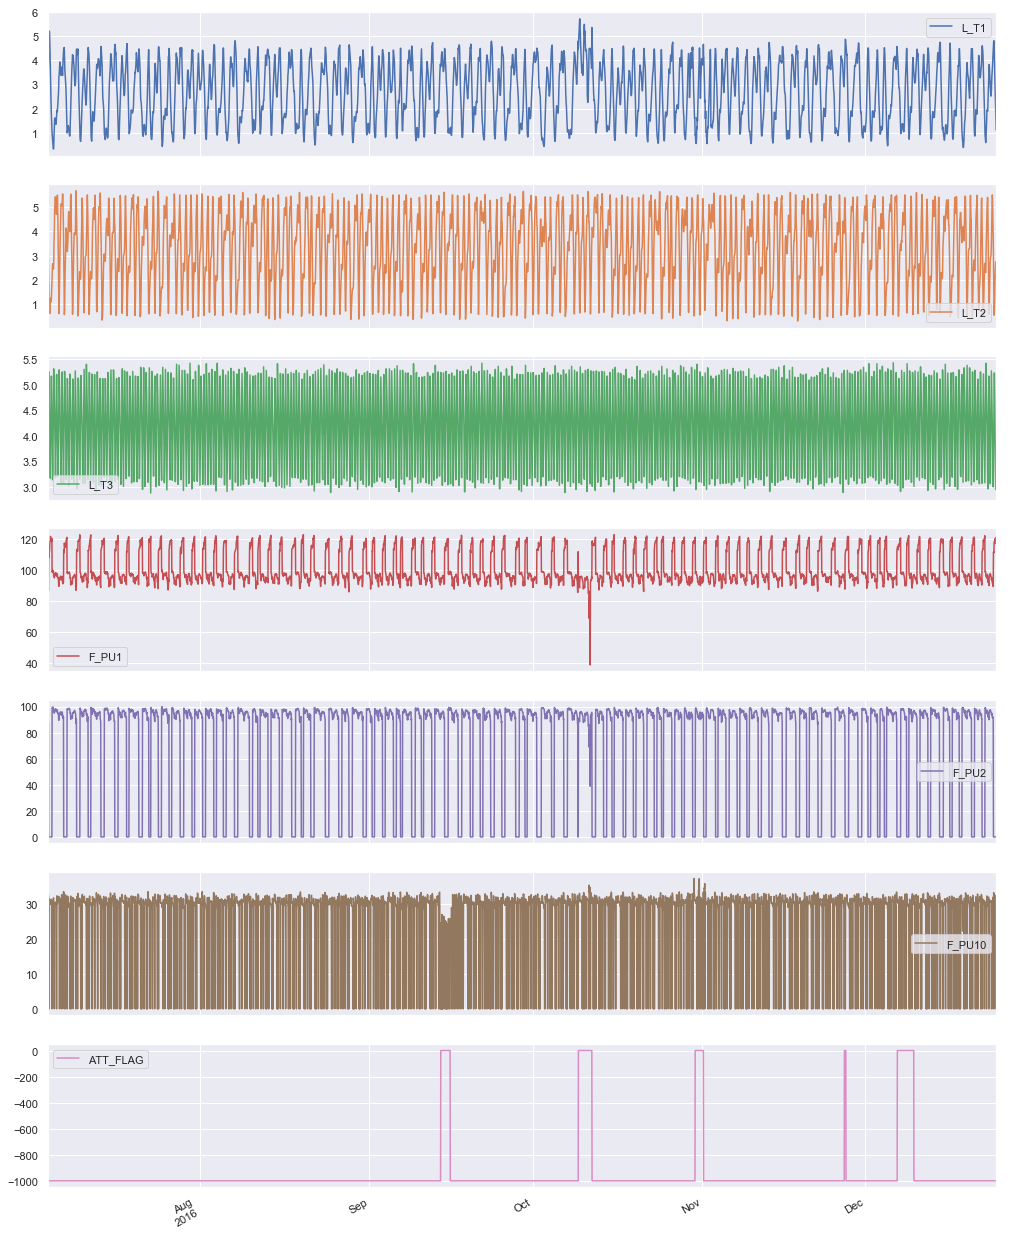

In [17]:
axes = data_trn_2[names + ['ATT_FLAG']].plot(figsize=(17, 3*8), subplots=True) 
plt.show()

In [18]:
test_signals = {}

for name in names:
    series = pd.Series(data_trn_2[name], data_trn_2.index)
    test_signals[name] = series
    display(series.head(2))

2016-07-04 00:00:00    2.44
2016-07-04 01:00:00    2.66
Freq: H, Name: L_T1, dtype: float64

2016-07-04 00:00:00    5.24
2016-07-04 01:00:00    4.53
Freq: H, Name: L_T2, dtype: float64

2016-07-04 00:00:00    3.19
2016-07-04 01:00:00    3.20
Freq: H, Name: L_T3, dtype: float64

2016-07-04 00:00:00    93.63
2016-07-04 01:00:00    89.41
Freq: H, Name: F_PU1, dtype: float64

2016-07-04 00:00:00    93.65
2016-07-04 01:00:00    89.43
Freq: H, Name: F_PU2, dtype: float64

2016-07-04 00:00:00    29.87
2016-07-04 01:00:00     0.00
Freq: H, Name: F_PU10, dtype: float64



Processing signal 'L_T1'


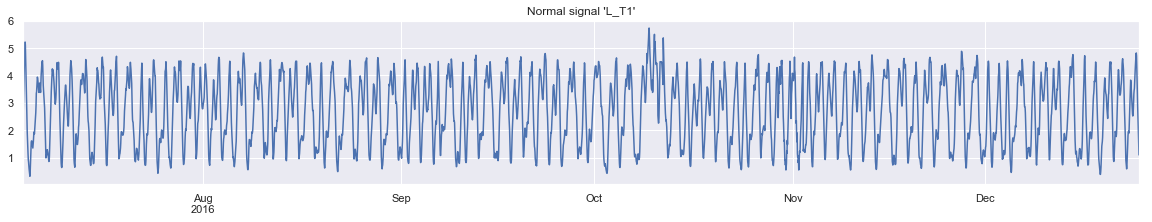

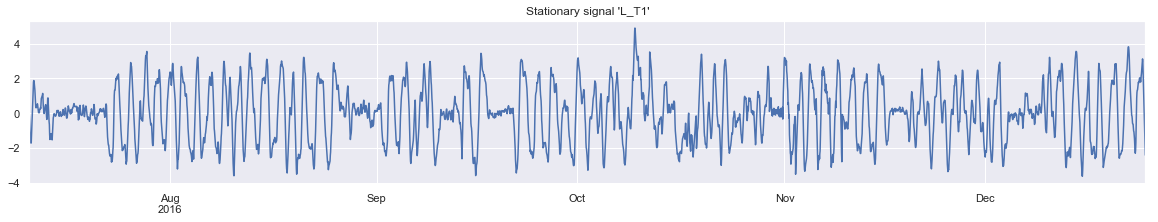



Processing signal 'L_T2'


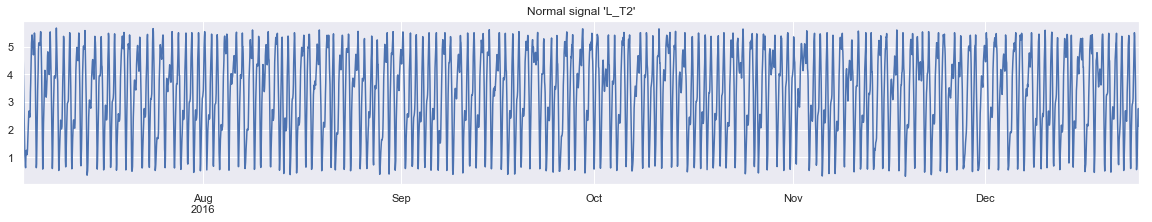

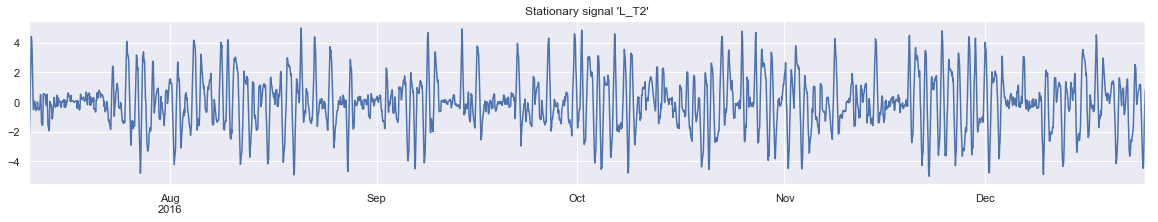



Processing signal 'L_T3'


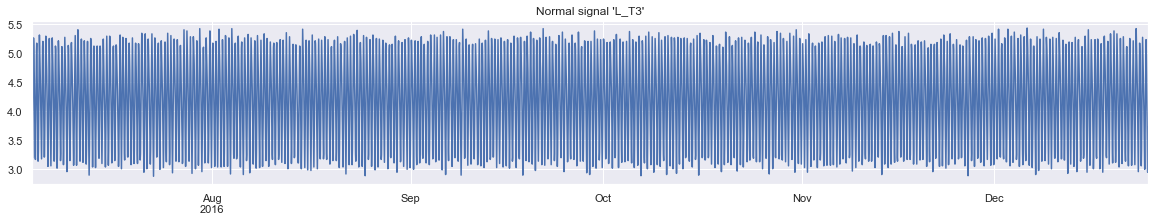

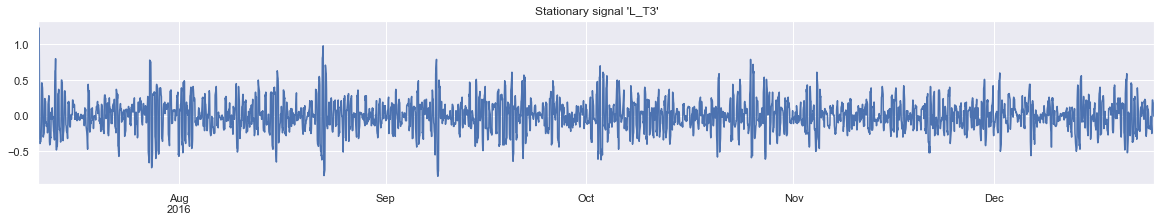



Processing signal 'F_PU1'


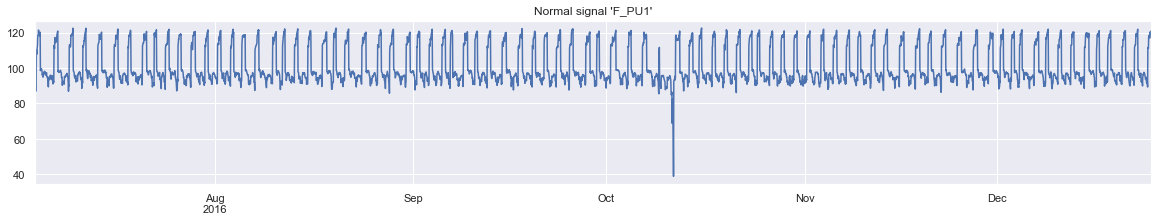

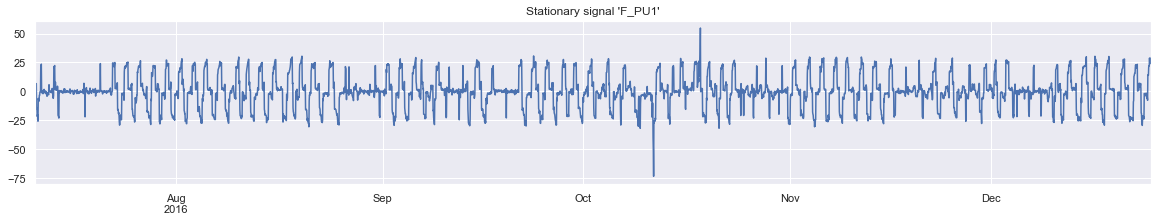



Processing signal 'F_PU2'


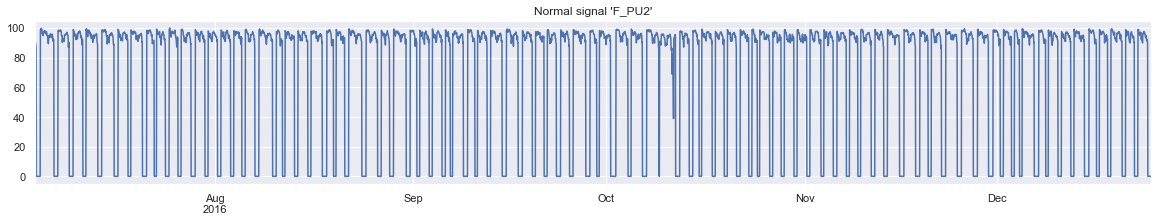

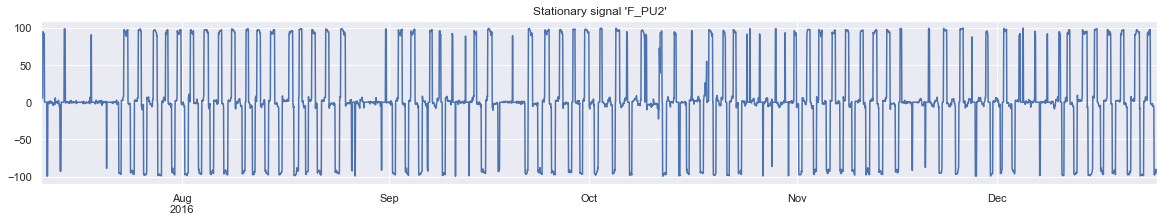



Processing signal 'F_PU10'


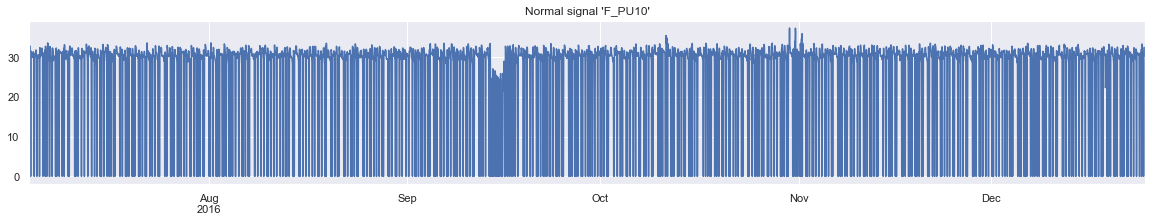

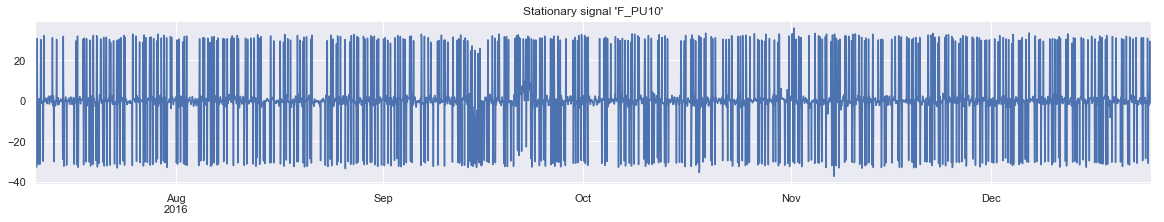

In [19]:
for test_signal in test_signals.keys():
    print(f"\n\nProcessing signal '{test_signal}'")
    
    test_series = test_signals[test_signal]
    
    # visualize it
    test_series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{test_signal}'")
    plt.show()
    
    test_stationary = difference(test_series)

    # visualize it
    test_stationary.plot(figsize=(20,3))
    plt.title(f"Stationary signal '{test_signal}'")
    plt.show()
              
    test_signals[test_signal] = test_stationary

## Predictions!

In [20]:
def make_detection_sarimax(trn_series, tst_series, order):
    
    new_test = tst_series.copy()
    
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    residuals = []
    start_idx = new_test.index[0]
    count = 0
    for tst_idx in new_test.index:
        mod_tst = sm.tsa.SARIMAX(new_test[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        residual = (output.values - new_test[tst_idx])**2
        residuals.append(residual)
#         if residual > threshold:
#             # keep predicting on predicted rather than observed (observed is anomalous!)
#             count += 1
#             new_test[tst_idx] = 0            
#     print(f"{count} residuals above threshold")

    return pd.Series(predictions, new_test.index), pd.Series(residuals, new_test.index)

To tune the threshold for the residuals, we use the MSE obtained during training (on normal behaviour) and then we perform grid search on a range of multipliers.

In [21]:
# values obtained during training (dataset 1) on normal behaviour.
# mean_squared_errors = {
#     'L_T1': 0.0742, # 0.0019,
#     'L_T2': 0.1899, # 0.0128,
#     'L_T3': 0.0082, #0.0154,
#     'L_T4': 0.1012, # 0.1389,
#     'L_T5': 0.3932, # 0.0377,
#     'L_T6': 0.0140, # 0.0127,
#     'L_T7': 0.1982, # 0.2381
# }

mean_squared_errors = {
    'L_T1': 0.0741,
    'L_T2': 0.1814,
    'L_T3': 0.0083,
    'F_PU1': 2.1945,
    'F_PU10': 260.0519,
    'F_PU2': 90.5943,
}

In [22]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function to retrieve entries of the confusion matrix
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    #print(result.shape[0])
    return result.shape[0]

In [23]:
# thres_multipliers = [1, 1.25, 1.5, 3, 5, 7, 10, 20, 30]
# labels = data_trn_2['ATT_FLAG'].iloc[delay:].map({-999:0, 1:1})

# signal = 'L_T1'
    
# print(f"\n------------------------------------\n\nPredicting '{signal}'")
# signal_data = signals[signal]
# test_signal = test_signals[signal]

# signal_data.plot(figsize=(17,3))
# plt.show()

# test_signal.plot(figsize=(17,3))
# plt.show()

# train = signal_data
# test = test_signal
# print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

In [24]:
# threshold = 5 * mean_squared_errors[signal]
# print(orders[signal])

# predictions, residuals = make_detection_sarimax(train, test, orders[signal], threshold)

In [25]:
# detection = pd.DataFrame(np.zeros(test.size), test.index)
# detection[residuals>threshold] = 1
# print(detection.size, predictions.size, residuals.size)

# res = pd.concat([labels[detection.index], detection], axis=1) # only take labels when predicted
# res.columns = ['true', 'pred']
# res.set_index(detection.index)

# t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
# t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
# f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
# f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

# #precision = t_p/(t_p + f_p)
# #recall = t_p/(t_p + f_n)                


# #f0_5 = ( 1 + 0.5**2) * ( precision * recall ) / (0.5**2 * precision + recall )

# print(f"Threshold: {threshold}")
# print(f"TP: {t_p}. FP:{f_p}. TN:{t_n}. FN: {f_n}")
# print(f"Prec: {precision}, Rec: {recall}")
# print(f"f0_5: {f0_5}")

# plt.figure(figsize=(17,3))
# plt.plot(test, color='blue', label='Test signal')
# plt.legend()
# plt.show()

# plt.figure(figsize=(17,3))
# plt.plot(predictions, color='salmon', label='Predicted signal')
# plt.legend()
# plt.show()

# plt.figure(figsize=(17,3))
# plt.plot(residuals, color='red', label='Residuals')
# threshold_series = pd.DataFrame(np.array([threshold for i in range(residuals.shape[0])]), residuals.index)
# plt.plot(threshold_series, color='green', label='Threshold for residuals')
# plt.yscale("log")
# plt.legend()
# plt.show()

# plt.figure(figsize=(17,3))
# plt.plot(detection, color='salmon', label='Detection')
# plt.plot(labels, color='red', label='True label')
# plt.legend()
# plt.show()

## Gridsearch on threshold value, per signal.


------------------------------------

Predicting 'L_T1'
8593 hours used for training, 4009 for testing.


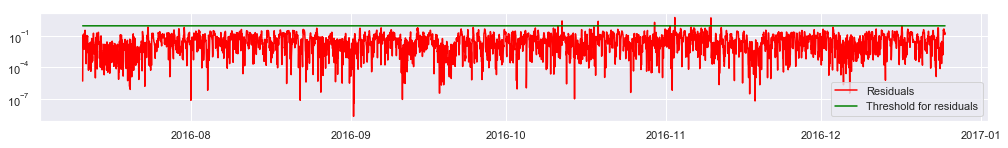

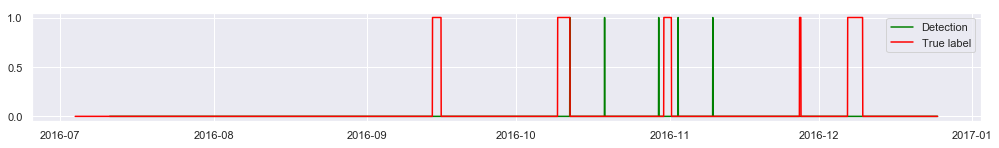

Best threshold for signal L_T1: 0.3315. F05: 0.061068702290076333

Threshold: 0.8892, Multiplier: 12.0
TP: 1. FP:4. TN:3786. FN: 218
Prec: 0.2, Rec: 0.0045662100456621
f0_5: 0.02092050209205021

------------------------------------

Predicting 'L_T2'
8593 hours used for training, 4009 for testing.


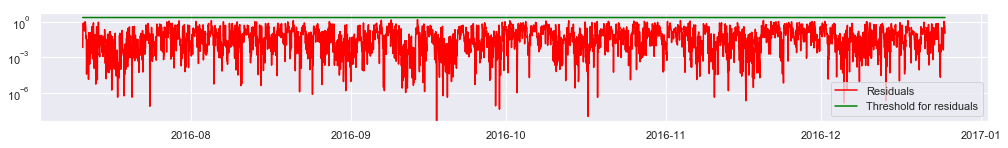

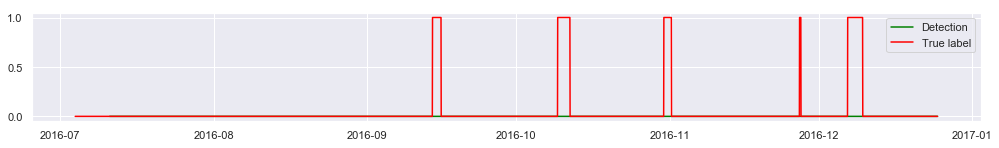

Best threshold for signal L_T2: 0.4964631578947369. F05: 0.04529616724738676

Threshold: 2.1768, Multiplier: 12.0
TP: 0. FP:0. TN:3790. FN: 219
Prec: 0, Rec: 0.0
f0_5: 0.02457002457002457

------------------------------------

Predicting 'L_T3'
8593 hours used for training, 4009 for testing.


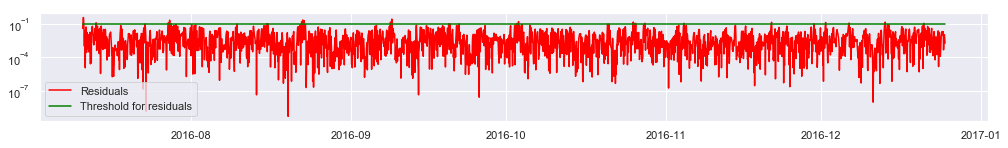

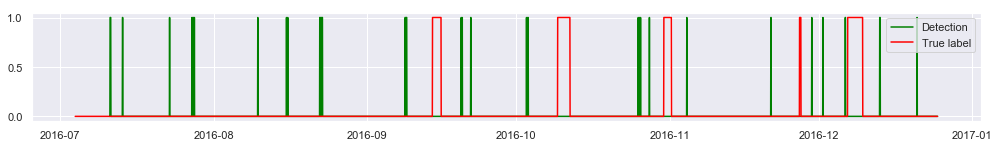

Best threshold for signal L_T3: 0.0083. F05: 0.06186518928901201

Threshold: 0.0996, Multiplier: 12.0
TP: 0. FP:52. TN:3738. FN: 219
Prec: 0.0, Rec: 0.0
f0_5: 0.007680491551459293

------------------------------------

Predicting 'F_PU1'
8593 hours used for training, 4009 for testing.


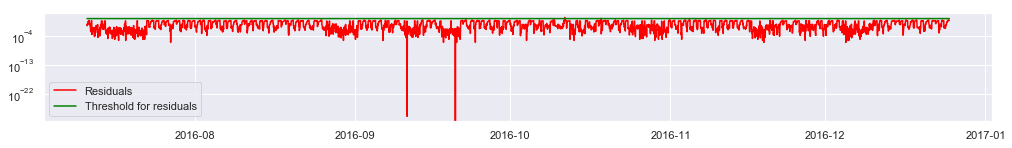

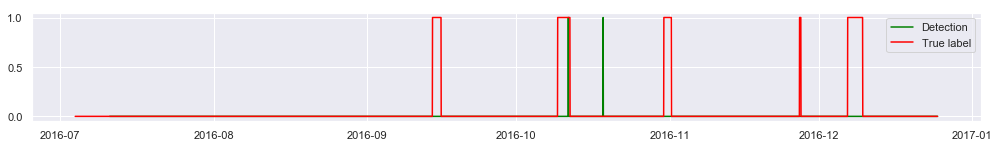

Best threshold for signal F_PU1: 8.547. F05: 0.08353221957040574

Threshold: 26.334000000000003, Multiplier: 12.0
TP: 2. FP:1. TN:3789. FN: 217
Prec: 0.6666666666666666, Rec: 0.0091324200913242
f0_5: 0.04329004329004329

------------------------------------

Predicting 'F_PU2'
8593 hours used for training, 4009 for testing.


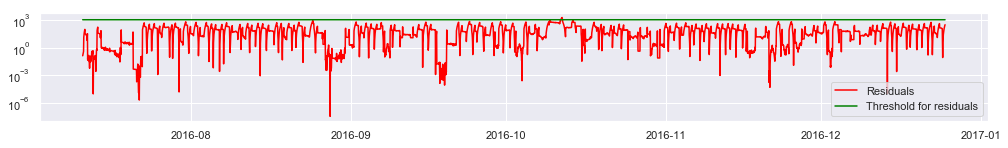

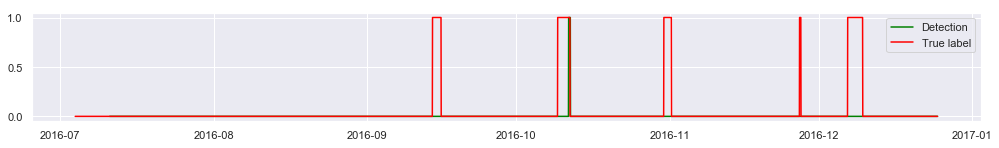

Best threshold for signal F_PU2: 510.188952631579. F05: 0.4

Threshold: 1087.1316000000002, Multiplier: 12.0
TP: 7. FP:2. TN:3788. FN: 212
Prec: 0.7777777777777778, Rec: 0.0319634703196347
f0_5: 0.1372549019607843

------------------------------------

Predicting 'F_PU10'
8593 hours used for training, 4009 for testing.


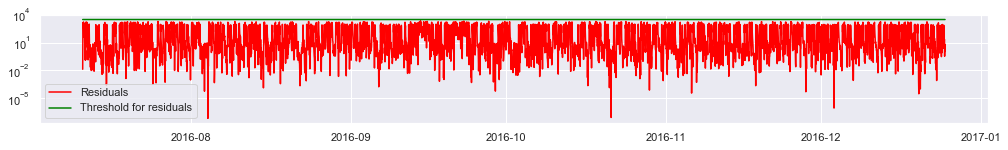

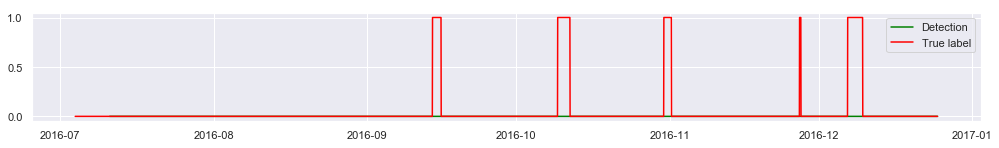

Best threshold for signal F_PU10: 1615.0591684210528. F05: 0.09306260575296109

Threshold: 3120.6228, Multiplier: 12.0
TP: 0. FP:0. TN:3790. FN: 219
Prec: 0, Rec: 0.0
f0_5: 0.02242152466367713


In [29]:
thres_multipliers = np.linspace(1, 12, 20)
labels = data_trn_2['ATT_FLAG'].iloc[1:].map({-999:0, 1:1})

for signal in signals.keys():
    f0_5_best = 0
    threshold_best = 0
    
    print(f"\n------------------------------------\n\nPredicting '{signal}'")
    signal_data = signals[signal]
    test_signal = test_signals[signal]

    train = signal_data
    test = test_signal
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions, residuals = make_detection_sarimax(train, test, orders[signal])
    
    for mult in thres_multipliers:
        threshold = mult * mean_squared_errors[signal]        
        
        detection = pd.DataFrame(np.zeros(test.size), test.index)
        detection[residuals>threshold] = 1
        
        res = pd.concat([labels[detection.index], detection], axis=1) # only take labels when predicted
        res.columns = ['true', 'pred']
        res.set_index(detection.index)
                
        t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
        t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
        f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
        f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

        try:
            precision = t_p/(t_p + f_p)
        except:
            precision = 0
        
        try:
            recall = t_p/(t_p + f_n)                
        except:
            recall = 0
            
        if (precision + recall ) == 0:
            continue

        f0_5 = ( 1 + 0.5**2) * ( precision * recall ) / (0.5**2 * precision + recall )
                
        if f0_5 > f0_5_best:
            f0_5_best = f0_5
            threshold_best = threshold
                        
#             plt.figure(figsize=(17,2))
#             plt.plot(test, color='blue', label='Test signal')
#             plt.legend()
#             plt.show()

#             plt.figure(figsize=(17,2))
#             plt.plot(predictions, color='salmon', label='Predicted signal')
#             plt.legend()
#             plt.show()

    # per signal
    plt.figure(figsize=(17,2))
    plt.plot(residuals, color='red', label='Residuals')
    threshold_series = pd.DataFrame(np.array([threshold for i in range(residuals.shape[0])]), residuals.index)
    plt.plot(threshold_series, color='green', label='Threshold for residuals')
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.figure(figsize=(17,2))
    plt.plot(detection, color='green', label='Detection')
    plt.plot(labels, color='red', label='True label')
    plt.legend()
    plt.show()  
    print(f"Best threshold for signal {signal}: {threshold_best}. F05: {f0_5_best}")
    print(f"\nThreshold: {threshold}, Multiplier: {mult}")
    print(f"TP: {t_p}. FP:{f_p}. TN:{t_n}. FN: {f_n}")
    print(f"Prec: {precision}, Rec: {recall}")
    print(f"f0_5: {f0_5}")

In [ ]:
# values obtained with gridsearch above
# multipliers = {
#     'L_T1': 7,
#     'L_T2': 1,
#     'L_T3': 1,
#     'L_T4': 2,
#     'L_T5': 1.1,
#     'L_T6': 1,
#     'L_T7': 1.1
# }

# multipliers = {
#     'L_T1': 4.33,
#     'L_T2': 2.57,
#     'L_T3': 1.69,
#     'F_PU1': 4.338,
#     'F_PU2': 5.6152,
#     'F_PU10': 6,
# }

Now, for each of these signals, we show our detection results


------------------------------------

Detecting 'L_T1'
8593 hours used for training, 4009 for testing.
Threshold is: 0.8892


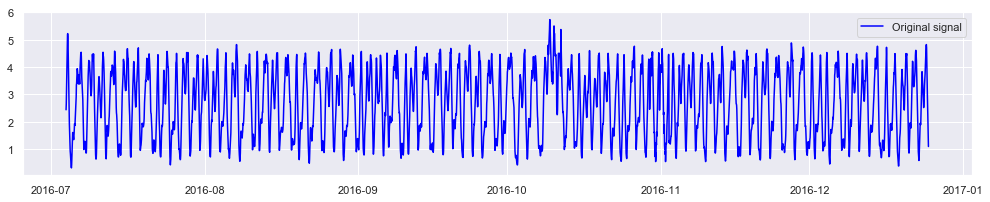

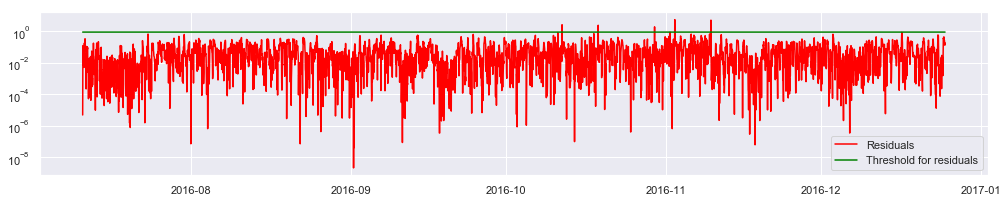

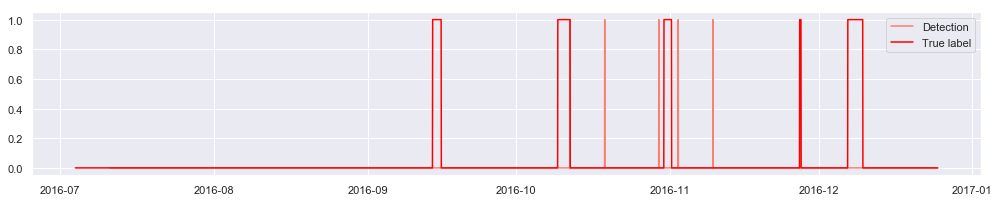


------------------------------------

Detecting 'L_T2'
8593 hours used for training, 4009 for testing.
Threshold is: 2.1768


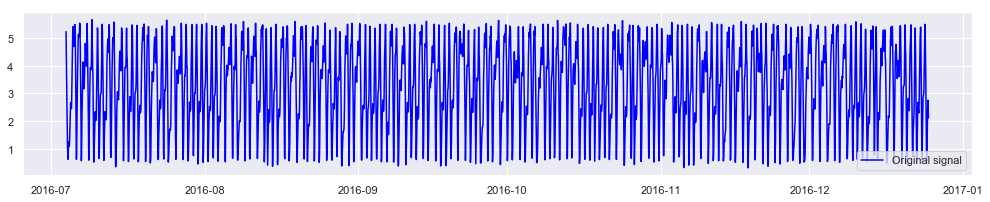

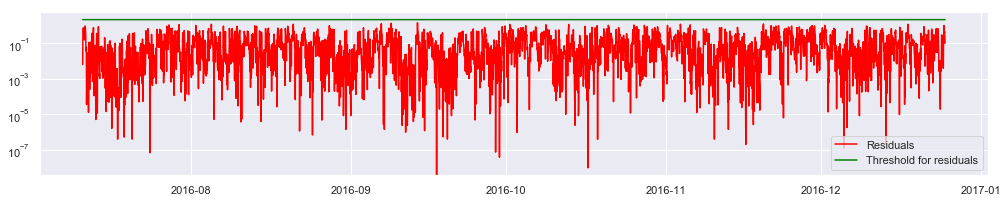

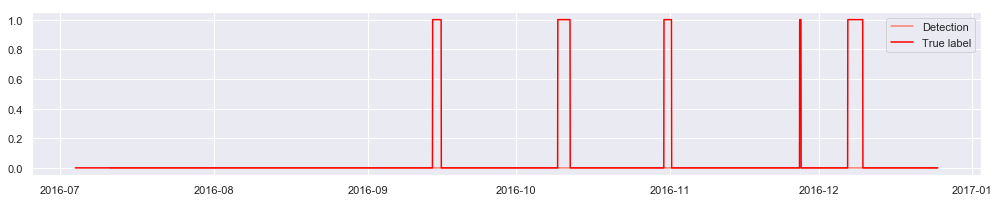


------------------------------------

Detecting 'L_T3'
8593 hours used for training, 4009 for testing.
Threshold is: 0.0996


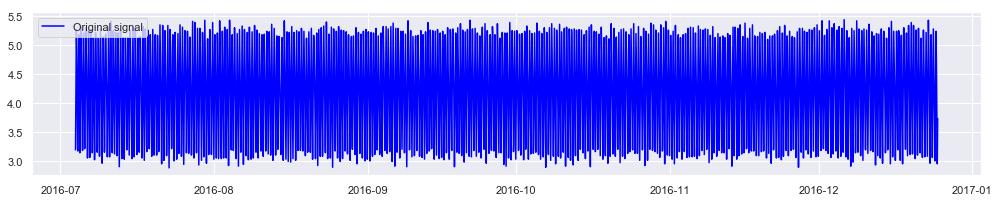

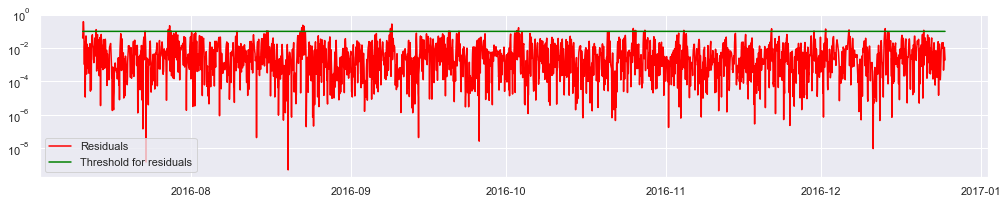

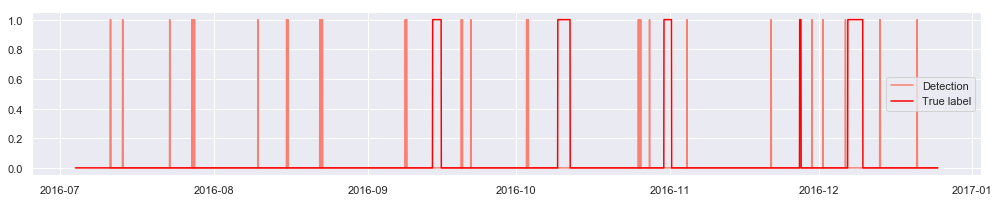


------------------------------------

Detecting 'F_PU1'
8593 hours used for training, 4009 for testing.
Threshold is: 26.334000000000003


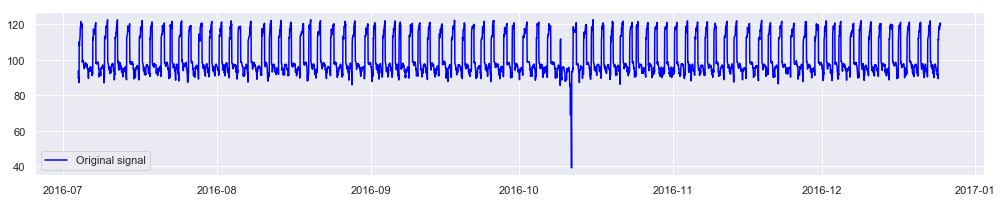

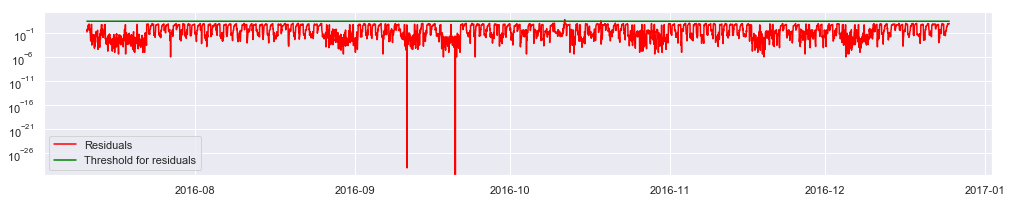

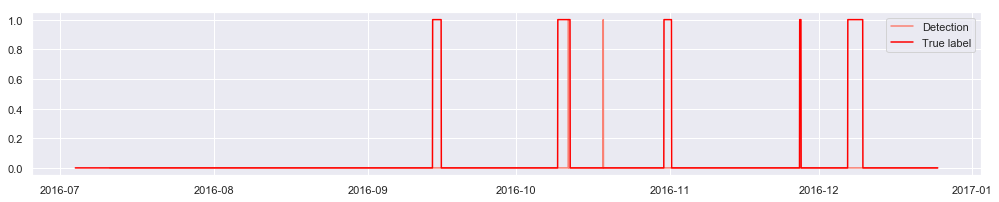


------------------------------------

Detecting 'F_PU2'
8593 hours used for training, 4009 for testing.
Threshold is: 1087.1316000000002


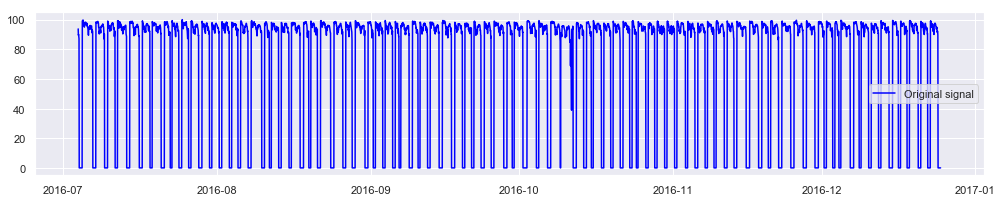

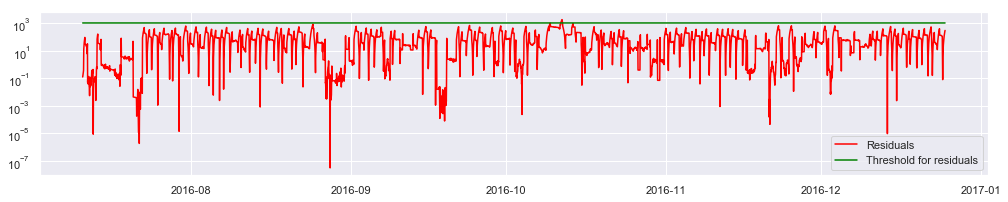

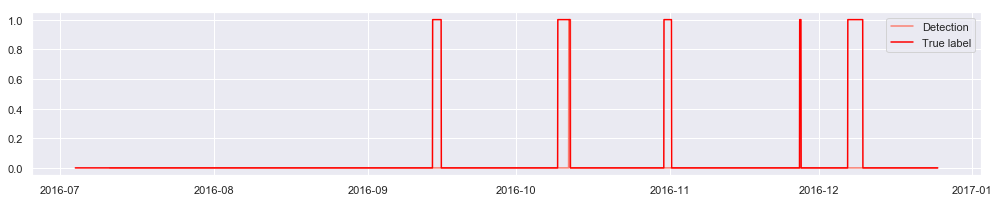


------------------------------------

Detecting 'F_PU10'
8593 hours used for training, 4009 for testing.
Threshold is: 3120.6228


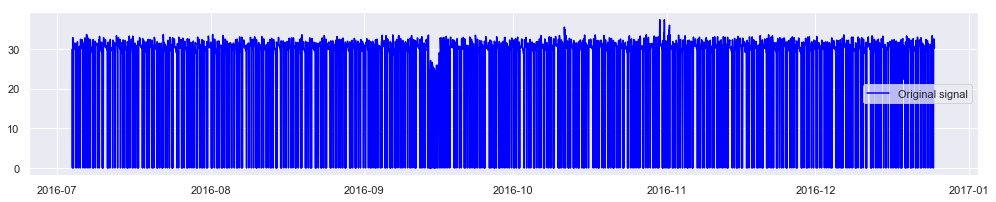

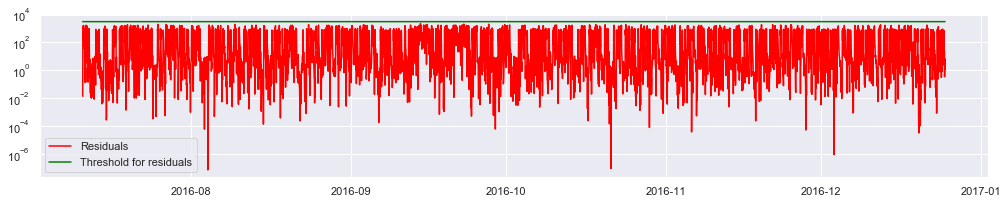

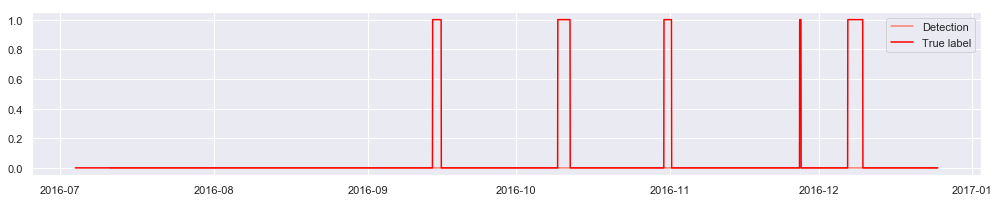

In [32]:
for signal in signals.keys():   
    print(f"\n------------------------------------\n\nDetecting '{signal}'")
    signal_data = signals[signal]
    test_signal = test_signals[signal]

    train = signal_data
    print(f"{train.shape[0]} hours used for training, {test_signal.shape[0]} for testing.")

    threshold = 12 * mean_squared_errors[signal]
    print(f"Threshold is: {threshold}")
    
    predictions, residuals = make_detection_sarimax(train, test_signal, orders[signal])

    detection = pd.DataFrame(np.zeros(test_signal.size), test_signal.index)
    detection[residuals>threshold] = 1
    
    plt.figure(figsize=(17,3))
    plt.plot(data_trn_2[signal], color='blue', label='Original signal')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(17,3))
    plt.plot(residuals, color='red', label='Residuals')
    threshold_series = pd.DataFrame(np.array([threshold for i in range(residuals.shape[0])]), residuals.index)
    plt.plot(threshold_series, color='green', label='Threshold for residuals')
    plt.yscale("log")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(17,3))
    plt.plot(detection, color='salmon', label='Detection')
    plt.plot(labels, color='red', label='True label')
    plt.legend()
    plt.show()   
    
            

    